In [2]:
#imported some packages I thought we might use
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import base64
import os
import seaborn as sns

In [8]:
#copied requirements from week 6 case, just because!
!pip install -r requirements.txt -q
!pip install -U notebook-as-pdf -q
#pyppeteer-install -> ran this from the terminal

In [6]:
#make sure you're in the right directory
os.chdir('C:\\Users\\intig\\Documents\\DS4A - Spring 2021\\Datasets')

## Data cleaning

We've downloaded and compiled various demographic data per zip code from the American Community Survey data exporter. Our goal is to merge these datasets with an additional dataset reporting functional internet speeds gathered via Microsoft devices and software.

In [9]:
#load all datasets. These are stored locally on my computer. Depending on where you store yours,
#you might have to write a different filepath

df_race = pd.read_csv("Final Datasets\\Race.csv")
df_income = pd.read_csv("Final Datasets\\Income_and_Poverty.csv")
df_ms_internet = pd.read_csv("Final Datasets\\Microsoft_internet_use.csv")
df_acs_internet = pd.read_csv("Final Datasets\\ACS_Internet.csv")
df_employment = pd.read_csv("Final Datasets\\Employment_Status.csv")
df_zcta = pd.read_csv("Final Datasets\\Zip_to_zcta_crosswalk_2020.csv")


C:\Users\intig\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\intig\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\intig\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, ce

In [10]:
# ##BELOW IS THE METHOD I USED FOR CLEANING.

# # re-index using named column values. Drop row with col names. Testing the function in the section below,
#keeping here in comments in case I need later.

# df_race.columns = df_race.loc[0]
# df_race=df_race.drop([0])
# # reformat zcta to 5 digits, remove the text
# df_race.iloc[0:,1] = df_race.iloc[0:,1].str.split().str[1]
# # remove all cols that contains "Margin"
# df_race=df_race[df_race.columns[~df_race.columns.str.contains("Margin")]]
    

In [42]:
#function to do an intial round of cleaning on the datasets. 
def clean_df(df):
    #removes the top row and makes the human-readable column header the main header.
    df.columns = df.loc[0]
    df=df.drop([0])
    # reformat zcta to 5 digits, remove the text
    df.iloc[0:,1] = df.iloc[0:,1].str.split().str[1]
    # remove all cols that contains "Margin"
    df=df[df.columns[~df.columns.str.contains("Margin")]]
    return df

In [60]:
#applying the cleaning function to all the dataframes
df_race=clean_df(df_race)
df_income=clean_df(df_income)
df_acs_internet=clean_df(df_acs_internet)
df_employment=clean_df(df_employment)

In [61]:
#merging one dataframe at a time. Adding suffixes, but only to the second dataframe.
df_demographics = pd.merge(df_race, df_income, on=["Geographic Area Name"], suffixes=("_race","_income"))
df_acs_internet=df_acs_internet.rename(columns={"id":"id_acs_internet","Estimate!!Total:":"Estimate!!Total:_acs_internet"})
df_demographics = pd.merge(df_demographics, df_acs_internet, on=["Geographic Area Name"], suffixes=(None,"_acs_internet"))
df_employment=df_employment.rename(columns={"id":"id_employment","Estimate!!Total:":"Estimate!!Total:_employment"})
df_demographics = pd.merge(df_demographics, df_employment, on=["Geographic Area Name"],  suffixes=("","_employment"))

In [64]:
#not entirely sure this is necessary, but had trouble merging becuase of data types.
df_ms_internet["POSTAL CODE"]=df_ms_internet["POSTAL CODE"].astype("object")

In [10]:
#CLEANING ZCTA FILE
#dropping rows of duplicate ZCTAs from the file. 
df_zcta=df_zcta.drop(df_zcta[df_zcta["ZIP_TYPE"]=="Post Office or large volume customer"].index)
df_zcta=df_zcta.drop(df_zcta[df_zcta["ZIP_TYPE"]=="populated ZCTA, missing ZIP"].index)
df_zcta=df_zcta.drop(df_zcta[df_zcta["zip_join_type"]=="Spatial join to ZCTA"].index)
#reformat to make sure each zip is actually 5-digits long
df_zcta["ZIP_CODE"]=df_zcta["ZIP_CODE"].apply('{:0>5}'.format)
df_zcta["ZIP_CODE"]=df_zcta["ZIP_CODE"].astype("int")

In [66]:
#merge the MS internet info with the ZCTA to merge with larger demographics
df_ms_internet = pd.merge(df_ms_internet, df_zcta[["ZIP_CODE","ZCTA"]], left_on = ["POSTAL CODE"], right_on=["ZIP_CODE"])
df_ms_internet = df_ms_internet[["BROADBAND USAGE","ZCTA"]]

In [67]:
#merge everything together. 
df_merged = pd.merge(df_demographics, df_ms_internet, left_on = "Geographic Area Name", right_on = "ZCTA")
df_merged=df_merged[df_merged.columns[~df_merged.columns.str.contains("id")]]

In [136]:
df_merged.to_csv(r"Merged_data_for_analysis_6.15.csv", index=False)

## Data analysis

Running some cutsssss!

In [93]:
#Transform to int type first
df_merged=df_merged[cols].apply(pd.to_numeric, errors='coerce')
df_merged["white_pct"]=df_merged['Estimate!!Total:!!White alone']/df_merged['Estimate!!Total:_race']
df_merged["black_pct"]=df_merged['Estimate!!Total:!!Black or African American alone']/df_merged['Estimate!!Total:_race']
df_merged["AmIn_pct"]=df_merged['Estimate!!Total:!!American Indian and Alaska Native alone']/df_merged['Estimate!!Total:_race']
df_merged["asian_pct"]=df_merged['Estimate!!Total:!!Asian alone']/df_merged['Estimate!!Total:_race']
df_merged["PI_pct"]=df_merged['Estimate!!Total:!!Native Hawaiian and Other Pacific Islander alone']/df_merged['Estimate!!Total:_race']
df_merged["OtherRace_pct"]=df_merged['Estimate!!Total:!!Some other race alone']/df_merged['Estimate!!Total:_race']
df_merged["two_races_pct"]=df_merged['Estimate!!Total:!!Two or more races:']/df_merged['Estimate!!Total:_race']

In [135]:
df_merged["white_pct"]=df_merged['Estimate!!Total:!!White alone']/df_merged['Estimate!!Total:_race']
df_merged["black_pct"]=df_merged['Estimate!!Total:!!Black or African American alone']/df_merged['Estimate!!Total:_race']
df_merged["AmIn_pct"]=df_merged['Estimate!!Total:!!American Indian and Alaska Native alone']/df_merged['Estimate!!Total:_race']
df_merged["asian_pct"]=df_merged['Estimate!!Total:!!Asian alone']/df_merged['Estimate!!Total:_race']
df_merged["PI_pct"]=df_merged['Estimate!!Total:!!Native Hawaiian and Other Pacific Islander alone']/df_merged['Estimate!!Total:_race']
df_merged["OtherRace_pct"]=df_merged['Estimate!!Total:!!Some other race alone']/df_merged['Estimate!!Total:_race']
df_merged["two_races_pct"]=df_merged['Estimate!!Total:!!Two or more races:']/df_merged['Estimate!!Total:_race']
df_merged["below_poverty_pct"]=df_merged['Estimate!!Total:!!Income in the past 12 months below poverty level:']/df_merged['Estimate!!Total:_income']

In [ ]:
#downloaded new ACS data S1501 https://data.census.gov/cedsci/table?q=educational%20attainment%20&tid=ACSST5Y2019.S1501
#for educational attainment because we want to look at everyone 25+ instead of 24-64.
ed= pd.read_csv("ACSST5Y2019.S1501_Educational_Attainment_2.csv")
ed=clean_df(ed)

#Keep only what we want 
ed=ed[["Geographic Area Name",
       "Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over",
      "Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!High school graduate or higher"]]

ed=ed.rename(columns={"Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!High school graduate or higher": "25+_HS_or_higher",
           "Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over" : "age_25+",
           "Geographic Area Name":"ZCTA"})
#to numeric
ed = ed.apply(pd.to_numeric)
#calculate %
ed["25+_HS_or_higher_pct"] = ed["25+_HS_or_higher"]/ed["age_25+"]

In [98]:
# we decided that the population for the ACS internet count would be the "anchor" population number.
#We've calculated the % breakdown of other demographics and, if needed, can calculate total counts by applying
#those %s to the "anchor" population.

df["tot_pop"] = df["Estimate!!Total:_acs_internet"]
df["yes_internet"] = df["Estimate!!Total:!!With an Internet subscription"]
df["yes_internet_25mbps"] = df["Estimate!!Total:!!With an Internet subscription!!Broadband of any type"]
df["no_internet"] = df["tot_pop"] - df["yes_internet"]
df["brdbnd_pct"] = df["yes_internet_25mbps"]/df["tot_pop"]

#Merge in new educational data
df = pd.merge(df, ed, left_on = "Geographic Area Name", right_on = "ZCTA")



Text(0, 0.5, 'brdbnd_pct')

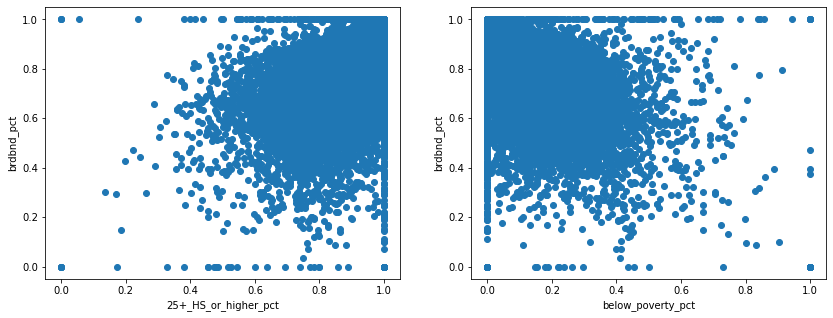

In [157]:
#I'd like to make some scatter plots. 

f = plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.scatter(df["25+_HS_or_higher_pct"],df["brdbnd_pct"])
plt.xlabel("25+_HS_or_higher_pct")
plt.ylabel("brdbnd_pct")

plt.subplot(1,2,2)
plt.scatter(df['below_poverty_pct'],df["brdbnd_pct"])
plt.xlabel("below_poverty_pct")
plt.ylabel("brdbnd_pct")

Text(0, 0.5, 'brdbnd_pct')

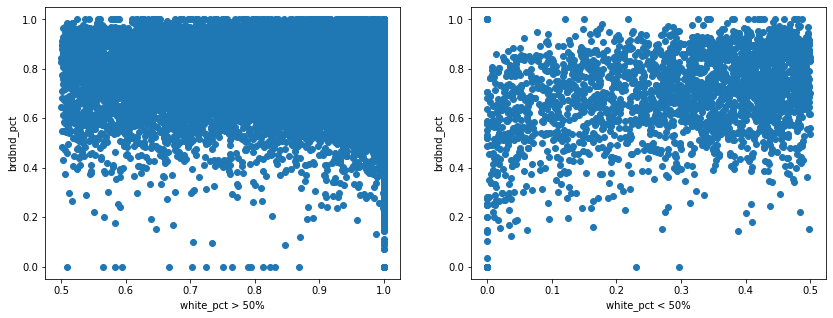

In [161]:
f = plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.scatter(df["white_pct"][df["white_pct"]>.5],df["brdbnd_pct"][df["white_pct"]>.5])
plt.xlabel("white_pct > 50%")
plt.ylabel("brdbnd_pct")

plt.subplot(1,2,2)
plt.scatter(df["white_pct"][df["white_pct"]<.5],df["brdbnd_pct"][df["white_pct"]<.5])
plt.xlabel("white_pct < 50%")
plt.ylabel("brdbnd_pct")

Text(0, 0.5, 'brdbnd_pct')

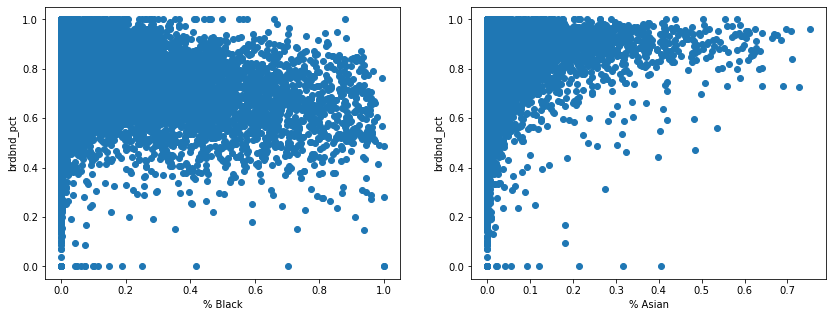

In [163]:
f = plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.scatter(df["black_pct"],df["brdbnd_pct"])
plt.xlabel("% Black")
plt.ylabel("brdbnd_pct")

plt.subplot(1,2,2)
plt.scatter(df["asian_pct"],df["brdbnd_pct"])
plt.xlabel("% Asian")
plt.ylabel("brdbnd_pct")

Text(0, 0.5, 'brdbnd_pct')

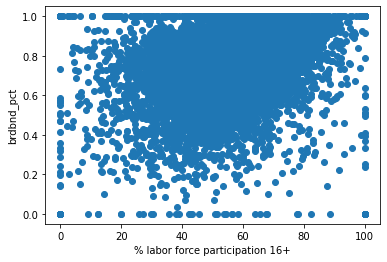

In [125]:
plt.scatter(df["Estimate!!Labor Force Participation Rate!!Population 16 years and over"],df["brdbnd_pct"])
plt.xlabel("% labor force participation 16+")
plt.ylabel("brdbnd_pct")

In [124]:
df_merged.to_csv(r"Merged_data_for_analysis_6.27.csv", index=False)

count    28170.000000
mean         0.778882
std          0.117293
min          0.036458
25%          0.714873
50%          0.793457
75%          0.863636
max          1.000000
Name: brdbnd_pct, dtype: float64

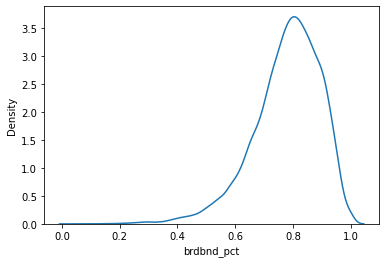

In [72]:
#Density plot  to check overall distribution.

sns.kdeplot(df2["brdbnd_pct"]);
df2["brdbnd_pct"].describe()

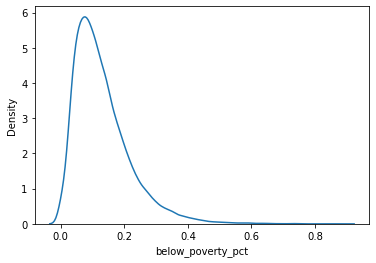

In [68]:
sns.kdeplot(df2["below_poverty_pct"]);

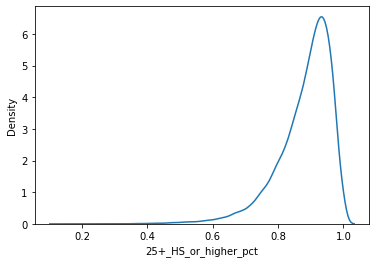

In [67]:
sns.kdeplot(df2["25+_HS_or_higher_pct"]);

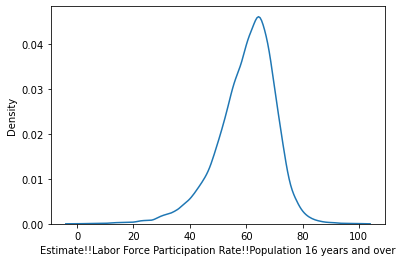

In [65]:
sns.kdeplot(df2["Estimate!!Labor Force Participation Rate!!Population 16 years and over"]);

We decided to add population density at the last minute. Below the steps

In [82]:
#re-import merged dataset
df = pd.read_csv("Merged_data_for_analysis_6.27.csv")
#re-import ZCTA file to be used for merger with zip code data that includes density.
df_zcta = pd.read_csv("Final Datasets\\Zip_to_zcta_crosswalk_2020.csv")

#Clean the ZCTA file by running steps above labeled "#CLEANING ZCTA FILE"

#Now, import zip data
df_zip = pd.read_csv("US Zip Code List.csv")

In [83]:
#Merge the two zip code files so that we have a single file with both ZCTA and pop density
df_zip_merged = pd.merge(df_zip, df_zcta, left_on = "zip", right_on = "ZIP_CODE")

In [84]:
#now, keep only the population and density variables we want
df_zip_merged = df_zip_merged[["population","density","ZCTA"]]

In [85]:
#now, merge into our main datafile.
#First, we need to make the main df ZCTA variable an int because it was an object for some reason.
df["Geographic Area Name"] = pd.to_numeric(df["Geographic Area Name"])
df_zip_merged["ZCTA"] = pd.to_numeric(df_zip_merged["ZCTA"])
df = pd.merge(df, df_zip_merged, left_on = "Geographic Area Name", right_on = "ZCTA")

In [86]:
#Because the density variable was stored as sq km, we'll first create a copy of the original variable,
#then transform it to reflect a variable expressed in sq miles.

df["density_sq_km"] = df["density"]
df["density"] = round(df["density"]*2.58999,0)

In [88]:
#Creating categories Urban, Rural, Mid-density
df["Urban"] = np.where(df["density"]>=1000,"Urban",np.nan)
df["Rural"] = np.where(df["density"]<=500,"Rural",np.nan)
df["Mid-density"] = np.where(((df["density"]>500) & (df["density"] < 1000)),"Mid-density",np.nan)

Text(0, 0.5, 'brdbnd_pct')

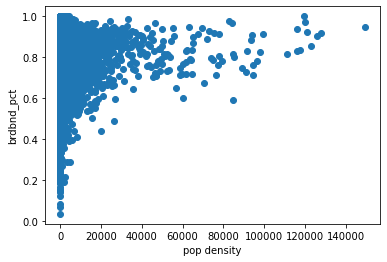

In [73]:
#additional scatterplot of density
plt.scatter(df2["density"],df2["brdbnd_pct"])
plt.xlabel("pop density")
plt.ylabel("brdbnd_pct")

In [115]:
df.to_csv(r"Merged_data_for_analysis_7.21.csv", index=False)

In [19]:
#FINAL REPORT STUFFFFF
df = pd.read_csv("Merged_data_for_analysis_7.21.csv")

In [36]:
#SEE WHAT THINGS LOOK LIKE WITH NO POP LESS THAN 100
df2=df[df["tot_pop"]>100].copy()

In [74]:
df2.to_csv(r"Merged_data_for_analysis_8.01.csv", index=False)

Text(0, 0.5, 'brdbnd_pct')

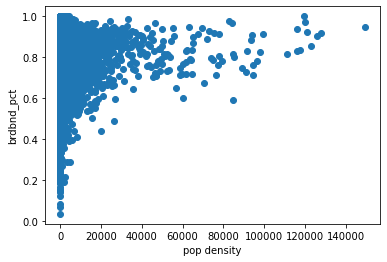

In [25]:
#Scatter plot a little clearer. 
plt.scatter(df2["density"],df2["brdbnd_pct"])
plt.xlabel("pop density")
plt.ylabel("brdbnd_pct")

Text(0, 0.5, '# of zip codes')

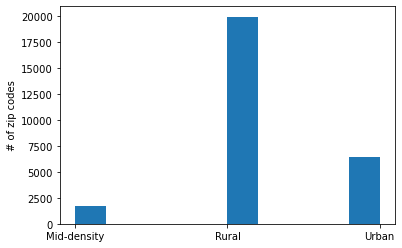

In [101]:
#general distribution of new density plot. Guess our breakdown wasn't totally accurate, but we'll use it!

plt.hist(df2["Density_class"])
plt.ylabel("# of zip codes")

<AxesSubplot:ylabel='Density'>

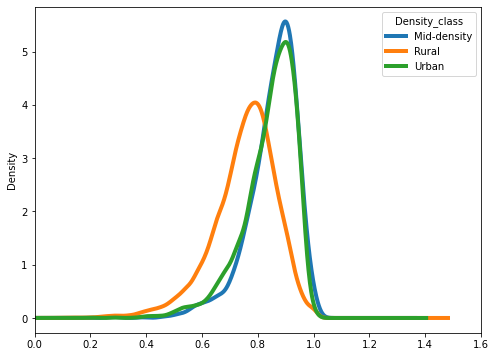

In [100]:
#check the differences. Definitely something there!
df2_densitywide=df2.pivot(columns="Density_class",values="brdbnd_pct")
df2_densitywide.plot.density(figsize=(8,6),xlim=(0,1.6),linewidth=4)

In [134]:
#Testing how the plotting works. 
# fig = sns.kdeplot(df2['sepal_width'], shade=True, color="r")
# fig = sns.kdeplot(df2['sepal_length'], shade=True, color="b")
# plt.show()

Text(0, 0.5, 'brdbnd_pct')

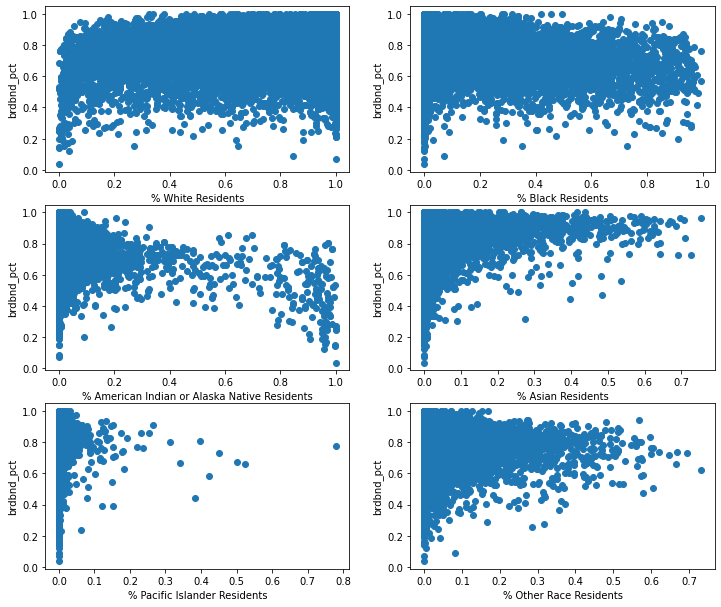

In [132]:
#Plot all races, you can really see the difference.
f = plt.figure(figsize=(12,14))

plt.subplot(4,2,1)
plt.scatter(df2['white_pct'],df2["brdbnd_pct"])
plt.xlabel("% White Residents")
plt.ylabel("brdbnd_pct")

plt.subplot(4,2,2)
plt.scatter(df2["black_pct"],df2["brdbnd_pct"])
plt.xlabel("% Black Residents")
plt.ylabel("brdbnd_pct")

plt.subplot(4,2,3)
plt.scatter(df2["AmIn_pct"],df2["brdbnd_pct"])
plt.xlabel("% American Indian or Alaska Native Residents")
plt.ylabel("brdbnd_pct")

plt.subplot(4,2,4)
plt.scatter(df2["asian_pct"],df2["brdbnd_pct"])
plt.xlabel("% Asian Residents")
plt.ylabel("brdbnd_pct")

plt.subplot(4,2,5)
plt.scatter(df2["PI_pct"],df2["brdbnd_pct"])
plt.xlabel("% Pacific Islander Residents")
plt.ylabel("brdbnd_pct")

plt.subplot(4,2,6)
plt.scatter(df2["OtherRace_pct"],df2["brdbnd_pct"])
plt.xlabel("% Other Race Residents")
plt.ylabel("brdbnd_pct")




Text(0, 0.5, 'brdbnd_pct')

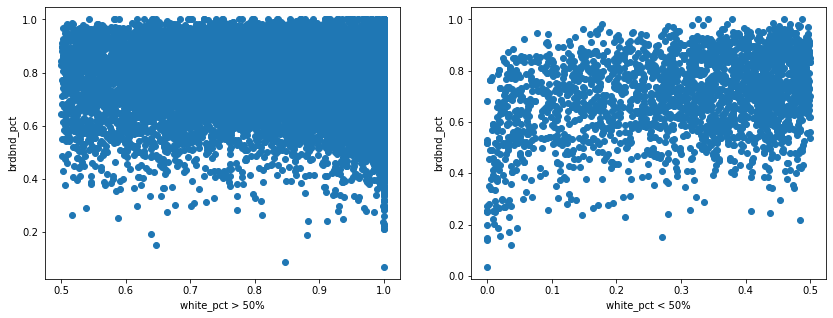

In [63]:
f = plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.scatter(df2["white_pct"][df["white_pct"]>.5],df2["brdbnd_pct"][df2["white_pct"]>.5])
plt.xlabel("white_pct > 50%")
plt.ylabel("brdbnd_pct")

plt.subplot(1,2,2)
plt.scatter(df2["white_pct"][df2["white_pct"]<.5],df2["brdbnd_pct"][df2["white_pct"]<.5])
plt.xlabel("white_pct < 50%")
plt.ylabel("brdbnd_pct")

Text(0, 0.5, 'brdbnd_pct')

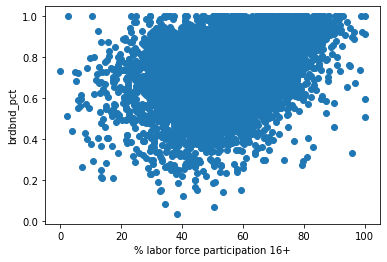

In [64]:
plt.scatter(df2["Estimate!!Labor Force Participation Rate!!Population 16 years and over"],df2["brdbnd_pct"])
plt.xlabel("% labor force participation 16+")
plt.ylabel("brdbnd_pct")